In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
g = nx.Graph()

In [3]:
g.add_nodes_from([
    (0, {'name':'bob', 'age':30, 'sexe':'male', 'job':'driver'}),
    (1, {'name':'sue', 'age':35, 'sexe':'female', 'job':'maid'}),
    (2, {'name':'barbara', 'age':32, 'sexe':'female', 'job':'unemployed'}),
    (3, {'name':'john', 'age':45, 'sexe':'male', 'job':'loaner'})
])

In [4]:
g.add_edges_from([
    (0,1),
    (1,2),
    (3,1)
])

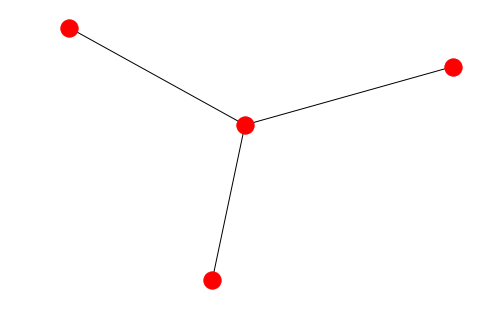

In [5]:
nx.draw(g)
plt.show()

In [6]:
A = nx.adj_matrix(g).todense()
A

matrix([[0, 1, 0, 0],
        [1, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 0]], dtype=int32)

In [7]:
nodes_names = nx.get_node_attributes(g,name='sexe')

In [8]:
# one hot encoding
rows = len(nodes_names)
rows

4

In [9]:
cols = list(nodes_names.values())
cols = sorted(cols)
d = {}
i = 0
for val in cols:
    if val not in d:
        d[val] = i
        i += 1
len(d)

2

In [10]:
d

{'female': 0, 'male': 1}

In [11]:
# matrix
a = np.zeros((rows,len(d)))
a

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [12]:
col_idx = [d[n] for n in nodes_names.values()]
col_idx

[1, 0, 0, 1]

In [13]:
a[np.arange(rows), col_idx] = 1
a

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]])

In [14]:
def one_hot_encoding(node_attr):
    '''return a feature matrix from nodes attribute dict'''
    rows = len(node_attr)
    cols = list(node_attr.values())
    cols = sorted(cols)
    d = {}
    i = 0
    for val in cols:
        if val not in d:
            d[val] = i
            i += 1
    # matrix
    a = np.zeros((rows,len(d)))
    col_idx = [d[n] for n in node_attr.values()]
    a[np.arange(rows), col_idx] = 1
    return a

In [15]:
one_hot_encoding(nodes_names)

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]])

In [16]:
one_hot_encoding(nx.get_node_attributes(g, name='age'))

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [17]:
nx.get_node_attributes(g, name='sexe')

{0: 'male', 1: 'female', 2: 'female', 3: 'male'}

In [18]:
one_hot_encoding(nx.get_node_attributes(g, name='sexe'))

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]])

# Graph Convolution Layer

$ Z = f(\tilde D^{-1}\tilde AXW)$

$f()$ is the activation function.   
$\tilde A$ is the adjacency matrix plus the identity matrix ($A+I$).  
$\tilde D$ is the diagonal degree matrix with $\tilde D_{ii} = \sum_j{\tilde A_{ij}}$  
$X$ is the nodes' features matrix as one_hot_encoded labels
$W$ is the weight matrix such as $W \in \Bbb R^{c\times c'}$

## Step 1: linear transformation $XW$

$X \in \Bbb R^{n \times c}$ matrix with $n$ the number of nodes and $c$ the length of the encoded features.

In [19]:
X = one_hot_encoding(nx.get_node_attributes(g, name='sexe'))

In [20]:
X.shape

(4, 2)

In [21]:
X

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]])

In [22]:
W = np.random.randn(X.shape[-1], 3)
W

array([[ 0.53636968, -1.36475796, -0.35472934],
       [ 0.45606681, -0.4509158 , -1.09385926]])

In [23]:
Y = np.dot(X,W)
Y

array([[ 0.45606681, -0.4509158 , -1.09385926],
       [ 0.53636968, -1.36475796, -0.35472934],
       [ 0.53636968, -1.36475796, -0.35472934],
       [ 0.45606681, -0.4509158 , -1.09385926]])

## Step 2: propagate weights
$ \tilde AXW$

In [43]:
# compute A
A = nx.adj_matrix(g).todense()
A = A.astype(np.float32)
A

matrix([[ 0.,  1.,  0.,  0.],
        [ 1.,  0.,  1.,  1.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.]], dtype=float32)

In [44]:
I = np.eye(A.shape[0])
I

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [45]:
tA = A + I
tA

matrix([[ 1.,  1.,  0.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 0.,  1.,  1.,  0.],
        [ 0.,  1.,  0.,  1.]])

In [46]:
tAY = np.dot(tA, Y)
tAY

matrix([[ 0.99243649, -1.81567376, -1.4485886 ],
        [ 1.98487298, -3.63134752, -2.89717719],
        [ 1.07273936, -2.72951592, -0.70945868],
        [ 0.99243649, -1.81567376, -1.4485886 ]])

## Step 3: normalize
To keep a fixed feature scale, we multiply by $\tilde D^{-1}_{ii}$.

In [47]:
# diagonal degree matrix
diag = A.sum(axis=1)
diag

matrix([[ 1.],
        [ 3.],
        [ 1.],
        [ 1.]], dtype=float32)

In [48]:
tD = np.diagflat(diag)
tD

matrix([[ 1.,  0.,  0.,  0.],
        [ 0.,  3.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.]], dtype=float32)

In [49]:
tD_1 = np.linalg.inv(tD)
tD_1

matrix([[ 1.        , -0.        , -0.        , -0.        ],
        [ 0.        ,  0.33333334,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]], dtype=float32)

In [50]:
DA = np.dot(tD_1, tAY)
DA

matrix([[ 0.99243649, -1.81567376, -1.4485886 ],
        [ 0.66162435, -1.21044921, -0.96572576],
        [ 1.07273936, -2.72951592, -0.70945868],
        [ 0.99243649, -1.81567376, -1.4485886 ]])

# Step 4: Activation

In [51]:
# ReLu
np.maximum(DA,0)

matrix([[ 0.99243649,  0.        ,  0.        ],
        [ 0.66162435,  0.        ,  0.        ],
        [ 1.07273936,  0.        ,  0.        ],
        [ 0.99243649,  0.        ,  0.        ]])

In [52]:
def GCN(X, out_dim):
    W = np.random.randn(X.shape[-1], out_dim)
    Y = np.dot(X,W)
    # compute A
    A = nx.adj_matrix(g).todense()
    I = np.eye(A.shape[0])
    tA = A + I
    tAY = np.dot(tA, Y)
    # diagonal degree matrix
    diag = A.sum(axis=1)
    tD = np.diagflat(diag)
    tD_1 = np.linalg.inv(tD)
    DA = np.dot(tD_1, tAY)
    return np.maximum(DA,0)

In [53]:
x0 = GCN(X, 5)
x1 = GCN(x0,3)
x2 = GCN(x1,1)
x2

matrix([[ 1.26335984],
        [ 1.34479208],
        [ 1.50765657],
        [ 1.26335984]])

## Keras implementation

In [66]:
from keras import backend as K
from keras.engine.topology import Layer
import tensorflow as tf

In [67]:
class GCN(Layer):
    def __init__(self, output_dim, g, **kwargs):
        self.output_dim = output_dim
        self.A = nx.adj_matrix(g).todense()
        self.A = self.A.astype(np.float32)
        super(GCN, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                     shape=(input_shape[1], self.output_dim),
                                     initializer='uniform',
                                     trainable=True)
        super(GCN, self).build(input_shape)
    
    def call(self, x):
        Y = K.dot(x,self.kernel)
        I = K.eye(self.A.shape[0])
        tA = A + I
        tAY = K.dot(tA, Y)
        # Diagonal degree matrix
        diag = K.sum(self.A, axis=1)
        tD = diag* I
        tD_1 = tf.matrix_inverse(tD)
        DA = K.dot(tD_1, tAY)
        return K.maximum(DA,0)
    
    def compute_output_shape(self, input_shape):
        return (input_shape, self.output_dim)

In [68]:
layer0 = GCN(output_dim=1, g=g)

In [69]:
from keras.layers import Input, Dense
from keras.models import Model

In [70]:
inputs = Input(shape=(4,))

In [76]:
x = GCN(8, g)(inputs)
x = GCN(4, g)(x)
preds = Dense(1, activation='softmax')(x)

In [77]:
model = Model(inputs=inputs, outputs=preds)
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [78]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
gcn_9 (GCN)                  ((None, 4), 8)            32        
_________________________________________________________________
gcn_10 (GCN)                 (((None, 4), 8), 4)       32        
_________________________________________________________________
dense_2 (Dense)              (((None, 4), 8), 1)       5         
Total params: 69
Trainable params: 69
Non-trainable params: 0
_________________________________________________________________
